<a href="https://colab.research.google.com/github/kiatkai96/Projects/blob/main/Drug_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Task: To come with a machine learning model to predict the drug type that should be given to a particular patient based on their characteristics and which drug type will suit them best. 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dimension reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Models
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
drugs = pd.read_csv("/content/drug200.csv")

description = ["Age of patient","Gender of patients","Blood Pressure Levels",
       "Cholesterol levels","Soduim to potassium Ration in Blood","Drug Type"]
drugs_descript = pd.DataFrame({"Column":drugs.columns,
                              "Description":description})
print(drugs_descript)
print(drugs.head())

# drugs data has 200 rows and 6 columns with no missing values

        Column                          Description
0          Age                       Age of patient
1          Sex                   Gender of patients
2           BP                Blood Pressure Levels
3  Cholesterol                   Cholesterol levels
4      Na_to_K  Soduim to potassium Ration in Blood
5         Drug                            Drug Type
   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY


M    104
F     96
Name: Sex, dtype: int64
HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64
HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64
DrugY    91
drugX    54
drugA    23
drugB    16
drugC    16
Name: Drug, dtype: int64


Text(0.5, 1.0, 'Drug')

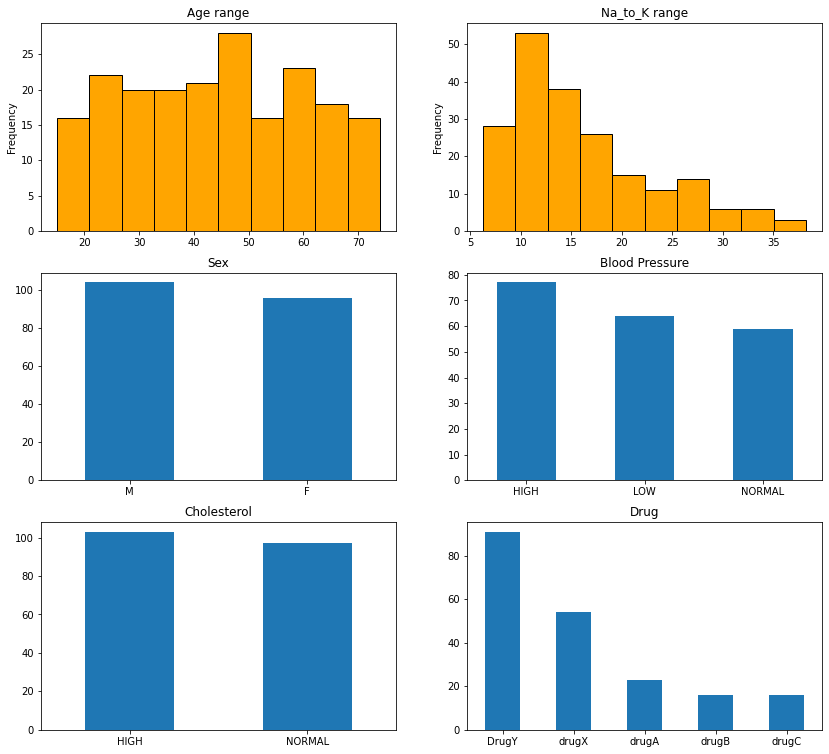

In [ ]:
# Summary statistics plot for the variables 
plt.figure(figsize=(14,13))

# Age
plt.subplot(3,2,1)
drugs.Age.plot(kind="hist", ec="black", color="orange")
plt.title("Age range")
# Age is ranged from 15 to 74 with majority of participants about 45 to 50 years old

# Na_to_K
plt.subplot(3,2,2)
drugs.Na_to_K.plot(kind="hist", ec="black", color="orange")
plt.title("Na_to_K range")

# Sex
plt.subplot(3,2,3)
print(drugs.Sex.value_counts())
drugs.Sex.value_counts().plot(kind="bar", rot=0)
plt.title("Sex")
# There are 96 Females and 104 Males in this dataset

# BP
plt.subplot(3,2,4)
print(drugs.BP.value_counts())
drugs.BP.value_counts().plot(kind="bar", rot=0)
plt.title("Blood Pressure")

# Cholesterol
plt.subplot(3,2,5)
print(drugs.Cholesterol.value_counts())
drugs.Cholesterol.value_counts().plot(kind="bar", rot=0)
plt.title("Cholesterol")

# Drug
plt.subplot(3,2,6)
print(drugs.Drug.value_counts())
drugs.Drug.value_counts().plot(kind="bar", rot=0)
plt.title("Drug")

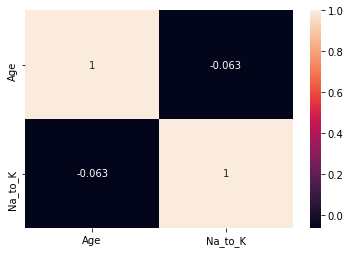

In [ ]:
# Correlation Matrix
sns.heatmap(drugs.corr(), annot=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 576x720 with 0 Axes>

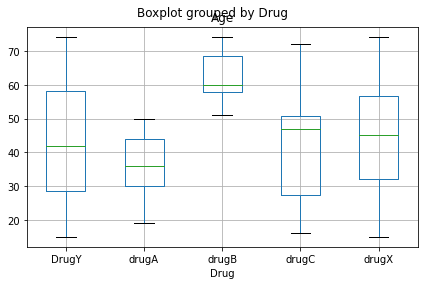

In [ ]:
plt.figure(figsize=(8,10))
# Boxplot of drug types
drugs.boxplot(column="Age",by="Drug" )
plt.tight_layout()\

# It seems like from the boxplots, patients of older ages of approximately 60 years old tend to be given drug B

In [ ]:
# We try to aggregate age into age groups
AgeGroup = []
for patient in range(len(drugs)):
  if drugs.iloc[patient].Age >= 15 and drugs.iloc[patient].Age <= 25:
    AgeGroup.append("15 to 25")
  elif drugs.iloc[patient].Age > 25 and drugs.iloc[patient].Age <= 35:
    AgeGroup.append("26 to 35")
  elif drugs.iloc[patient].Age > 35 and drugs.iloc[patient].Age <= 45:
    AgeGroup.append("36 to 45")
  elif drugs.iloc[patient].Age > 45 and drugs.iloc[patient].Age <= 55:
    AgeGroup.append("45 to 55")
  elif drugs.iloc[patient].Age > 55 and drugs.iloc[patient].Age <= 65:
    AgeGroup.append("56 to 65")
  elif drugs.iloc[patient].Age > 65 and drugs.iloc[patient].Age <= 75:
    AgeGroup.append("66 to 74")

drugs["AgeGroup"] = AgeGroup
drugs.head()  

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,AgeGroup
0,23,F,HIGH,HIGH,25.355,DrugY,15 to 25
1,47,M,LOW,HIGH,13.093,drugC,45 to 55
2,47,M,LOW,HIGH,10.114,drugC,45 to 55
3,28,F,NORMAL,HIGH,7.798,drugX,26 to 35
4,61,F,LOW,HIGH,18.043,DrugY,56 to 65


In [ ]:
# Dataframe to contain model results
model_results = pd.DataFrame(columns=["Models","Accuracy Score","F1 Score"])

# Create a function that takes in different model and compute the metrics for comparison
def model_accuracy(X, Y, model, model_name, model_results=None):
  X_train, X_test, ytrain, ytest = train_test_split(X, Y, train_size=0.8, random_state=10)
  model = model.fit(X_train, ytrain)
  predictions  = model.predict(X_test)
  score = accuracy_score(predictions, ytest)  # accuracy score
  f1 = f1_score(predictions, ytest, average="macro") # F1 score  

  if model_results is not None:
    model_results = model_results.append(pd.DataFrame({"Models":model_name,
                                                        "Accuracy Score":score,
                                                          "F1 Score":f1},
                                                             index = [0]),
                                                              ignore_index = True)
    return model_results

In [ ]:
# Scale the data first
Y = drugs.Drug
X = drugs.drop(["Drug","Age"], axis=1)
X_dummy = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummy)

model_results = model_accuracy(X_scaled, Y, SVC(), "Support Vector Machine", model_results)
model_results = model_accuracy(X_scaled, Y, LinearDiscriminantAnalysis(), "Linear Discriminant Analysis", model_results)
model_results = model_accuracy(X_scaled, Y, LogisticRegression(), "Logistic Regression", model_results)
model_results = model_accuracy(X_scaled, Y, DecisionTreeClassifier(), "Decision Tree", model_results)
model_results = model_accuracy(X_scaled, Y, RandomForestClassifier(), "Random Forest", model_results)
model_results = model_accuracy(X_scaled, Y, GaussianNB(), "Naive Bayes", model_results)
print(model_results)

                         Models  Accuracy Score  F1 Score
0        Support Vector Machine           0.650  0.522424
1  Linear Discriminant Analysis           0.850  0.801429
2           Logistic Regression           0.925  0.854451
3                 Decision Tree           1.000  1.000000
4                 Random Forest           0.950  0.871429
5                   Naive Bayes           0.700  0.755792
